In [27]:
def perf_from_monthly(returns, nav, rf_annual=0.0, freq=12):
    n = len(returns)
    years = n / freq if n else np.nan
    start_nav, end_nav = float(nav.iloc[0]), float(nav.iloc[-1])
    cagr = (end_nav / start_nav) ** (1 / years) - 1 if years and years > 0 else np.nan
    mu_m = float(returns.mean())
    sd_m = float(returns.std(ddof=1))
    ann_vol = sd_m * np.sqrt(freq) if not np.isnan(sd_m) else np.nan
    rf_m = (1 + rf_annual) ** (1 / freq) - 1
    sharpe = ((mu_m - rf_m) / sd_m * np.sqrt(freq)) if sd_m not in (0, np.nan) else np.nan
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    max_dd = float(dd.min()) if len(dd) else np.nan
    calmar = (cagr / abs(max_dd)) if (max_dd and max_dd < 0) else np.nan
    win_rate = float((returns > 0).mean())
    best_m = float(returns.max())
    worst_m = float(returns.min())
    return {"Months": n, "CAGR": cagr, "Ann.Vol": ann_vol, "Sharpe(ann.)": sharpe,
                "Max Drawdown": max_dd, "Calmar": calmar, "Best Month": best_m,
                "Worst Month": worst_m, "Win Rate": win_rate}

def pretty(name, m):
    print(f"\n== {name} ==")
    for k, v in m.items():
        if isinstance(v, (int, np.integer)):
            print(f"{k:>14}: {v}")
        elif isinstance(v, (float, np.floating)):
            if k in ["Sharpe(ann.)","Calmar"]:
                print(f"{k:>14}: {v:.2f}")
            elif k in ["Months"]:
                print(f"{k:>14}: {int(v)}")
            else:
               print(f"{k:>14}: {v:.2%}")
        else:
            print(f"{k:>14}: {v}")

Months in df: 31

== Strategy (DDQN) ==
        Months: 31
          CAGR: 17.24%
       Ann.Vol: 12.73%
  Sharpe(ann.): 1.23
  Max Drawdown: -7.53%
        Calmar: 2.29
    Best Month: 8.08%
   Worst Month: -5.36%
      Win Rate: 64.52%

== Benchmark (SPY) ==
        Months: 31
          CAGR: 18.77%
       Ann.Vol: 15.20%
  Sharpe(ann.): 1.11
  Max Drawdown: -9.24%
        Calmar: 2.03
    Best Month: 9.13%
   Worst Month: -9.24%
      Win Rate: 64.52%


/var/folders/gk/tqz928vx1m96n53nylzj1y800000gn/T/ipykernel_12072/2730118473.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df1.groupby("step", group_keys=False).apply(lambda g: g.iloc[[-1]])


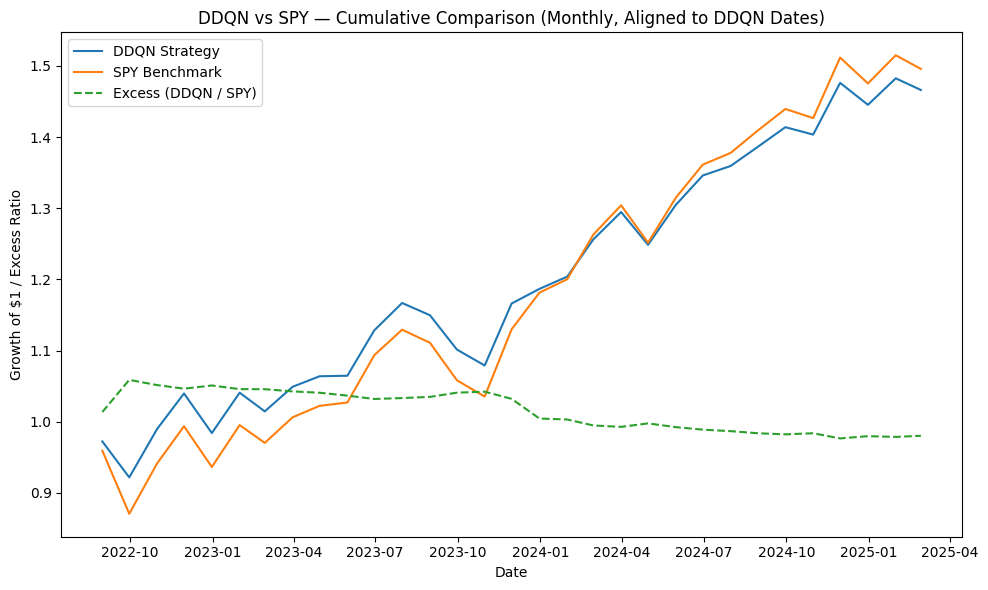

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("portfolio_weights/weights.csv")
df1 = df[df["episode"] == 501].copy()
df1 = df[df["episode"] == 501].copy()
df1 = df1.groupby("step", group_keys=False).apply(lambda g: g.iloc[[-1]])
# 定義起始日期
anchor_date = pd.Timestamp("2022-06-30")

# 找出所有 step（排序，避免亂序）
unique_steps = sorted(df1["step"].unique())

# 建立 step → date 對應表
step_to_date = {}
for i, s in enumerate(unique_steps):
    # anchor_date + i 個月，再取當月底
    step_to_date[s] = (anchor_date + pd.DateOffset(months=i)).replace(day=1) + pd.offsets.MonthEnd(0)

# 套用映射
df1["date"] = df1["step"].map(step_to_date)
df1 = df1.rename(columns={
    "stock_0_weight":"DBC_weight",
    "stock_1_weight":"SHY_weight" ,
    "stock_2_weight":"SPY_weight"
})
df2 = df1[['date','DBC_weight','SHY_weight','SPY_weight']]
df3 = df2.iloc[:-1]
df3.to_csv("DDQN_portfolio.csv",index=False)

# DDQN vs SPY 大盤(權重初始期間開始)
start_date = pd.Timestamp("2022-07-31")
end_date   = pd.Timestamp("2025-03-31")

# 讀檔
w = pd.read_csv("DDQN_portfolio.csv")     
r = pd.read_csv("ticker_all.csv")         

# 日期格式
w["date"] = pd.to_datetime(w["date"])
r["Date"] = pd.to_datetime(r["Date"])

# 篩期
w = w[(w["date"] >= start_date) & (w["date"] <= end_date)].reset_index(drop=True)
r = r[(r["Date"] >= start_date) & (r["Date"] <= end_date)].reset_index(drop=True)

#  去除同月份重複權重（保留月底最後一筆）
w = (w.sort_values("date")
       .groupby(w["date"].dt.to_period("M"))
       .tail(1)
       .reset_index(drop=True))

# 權重 shift：6/30 權重 -> 7 月報酬
weight_cols = [c for c in ["DBC_weight","SHY_weight","SPY_weight"] if c in w.columns]
if not weight_cols:
    raise ValueError("找不到權重欄位（*_weight）。至少需要 DBC_weight/SHY_weight/SPY_weight")

w[weight_cols] = w[weight_cols].shift(1)
w = w.dropna(subset=weight_cols).reset_index(drop=True)

# 權重正規化
row_sum = w[weight_cols].sum(axis=1)
mask = row_sum > 0
w.loc[mask, weight_cols] = w.loc[mask, weight_cols].div(row_sum[mask], axis=0)

# 合併報酬
df = w.merge(r, left_on="date", right_on="Date", how="inner")

ret_map = {"DBC_weight": "DBCReturn(M)",
           "SHY_weight": "SHYReturn(M)",
           "SPY_weight": "SPYReturn(M)"}
if "cash_weight" in weight_cols:
    df["cash_ret"] = 0.0
    ret_map["cash_weight"] = "cash_ret"

missing = [c for c in ret_map.values() if c not in df.columns]
if missing:
    raise ValueError(f"缺少回報欄位：{missing}")

df["strategy_ret"] = sum(df[w_col].astype(float) * df[r_col].astype(float)
                         for w_col, r_col in ret_map.items())

# 策略 NAV
df = df.sort_values("date").reset_index(drop=True)
df["strat_nav"] = (1.0 + df["strategy_ret"]).cumprod()

# Benchmark（SPY）以策略月份對齊
bench = r[["Date","SPYReturn(M)"]].rename(columns={"Date": "date"})
bench = df[["date"]].merge(bench, on="date", how="left")
bench["bench_nav"] = (1.0 + bench["SPYReturn(M)"]).cumprod()

# 合併
df = df.merge(bench[["date","bench_nav","SPYReturn(M)"]], on="date", how="left")
df["excess_nav"] = df["strat_nav"] / df["bench_nav"]

# 確認月份數
print("Months in df:", df["date"].nunique())

# 績效計算
strat_m = perf_from_monthly(df["strategy_ret"], df["strat_nav"], rf_annual=0.0, freq=12)
bench_m = perf_from_monthly(df["SPYReturn(M)_x"], df["bench_nav"], rf_annual=0.0, freq=12)

pretty("Strategy (DDQN)", strat_m)
pretty("Benchmark (SPY)", bench_m)

# 畫圖
plt.figure(figsize=(10,6))
plt.plot(df["date"], df["strat_nav"], label="DDQN Strategy")
plt.plot(df["date"], df["bench_nav"], label="SPY Benchmark")
plt.plot(df["date"], df["excess_nav"], label="Excess (DDQN / SPY)", linestyle="--")
plt.title("DDQN vs SPY — Cumulative Comparison (Monthly, Aligned to DDQN Dates)")
plt.xlabel("Date")
plt.ylabel("Growth of $1 / Excess Ratio")
plt.legend()
plt.tight_layout()
plt.show()